In [1]:
# This script analyzes data for housing market using HPI trend data to help predict future house prices.

In [2]:
# Data originates from https://catalog.data.gov/dataset/fhfa-house-price-indexes-hpis

In [3]:
# Import libraries needed
import random
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
import seaborn
import sklearn
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.cross_validation import cross_val_score
from IPython.display import Image
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from matplotlib.pylab import rcParams
from sklearn.decomposition import PCA
#from wordcloud import WordCloud, STOPWORDS
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score
import os

plt.style.use('seaborn')

#rcParams['figure.figsize'] = 15, 5

In [4]:
data = pd.read_csv('data.csv')

In [5]:
#Determine Dataset size and preview dataset from first few rows
print(len(data))
data.head()

840


,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,New Listings YoY,Inventory,Inventory MoM,Inventory YoY,Days on Market,Days on Market MoM,Days on Market YoY,Average Sale To List,Average Sale To List MoM,Average Sale To List YoY
0,National,2/1/2012,"$160,000",0.50%,-1.90%,303936,10.50%,15.20%,512356,7.50%,6.00%,2076987,1.10%,-16.20%,97,1,-10,95.80%,0.20%,0.30%
1,National,3/1/2012,"$171,000",6.80%,3.90%,393232,29.40%,7.50%,621362,21.30%,-4.40%,2118297,2.00%,-16.30%,93,-4,-12,96.20%,0.40%,0.60%
2,National,4/1/2012,"$178,000",4.20%,6.10%,403868,2.70%,8.60%,606292,-2.40%,-1.80%,2154547,1.70%,-16.40%,81,-12,-16,96.50%,0.30%,0.70%
3,National,5/1/2012,"$186,000",4.60%,8.00%,463304,14.70%,16.60%,608212,0.30%,0.30%,2162477,0.40%,-16.90%,72,-9,-17,96.90%,0.30%,1.00%
4,National,6/1/2012,"$194,000",4.20%,7.60%,486816,5.10%,9.80%,574060,-5.60%,-3.00%,2145129,-0.80%,-17.20%,68,-4,-16,97.00%,0.20%,1.00%


In [6]:
# Determine measures of Center Using Statistics Package to understand Home Sale statistics
MSP = list(data[data['Region'] == 'National']['Homes Sold'])
print('Mean of Homes Sold per Period Nationally: %f'%statistics.mean(MSP))
print('Median of Homes Sold per Period Nationally: %f'%statistics.median(MSP))
print('Mode of Homes Sold per Period Nationally: %s'%statistics.mode(MSP))

Mean of Homes Sold per Period Nationally: 506108.958333
Median of Homes Sold per Period Nationally: 504248.500000
Mode of Homes Sold per Period Nationally: 303936


In [7]:
# Repeat for Seattle Area
MSP_Sea = list(data[data['Region'] == 'Seattle, WA metro area']['Homes Sold'])
print('Mean of Homes Sold per Period Seattle: %f'%statistics.mean(MSP_Sea))
print('Median of Homes Sold per Period Seattle: %f'%statistics.median(MSP_Sea))
print('Mode of Homes Sold per Period Seattle: %s'%statistics.mode(MSP_Sea))

Mean of Homes Sold per Period Seattle: 4000.525000
Median of Homes Sold per Period Seattle: 3980.500000
Mode of Homes Sold per Period Seattle: 3769


In [8]:
#Transform data to allow for time series analysis with datetime data splitting into date componenets. 
List_ = list(data['Month of Period End'])

List_ = [datetime.datetime.strptime(x, "%m/%d/%Y") for x in List_]
data['mod'] = pd.Series(List_,index=data.index)
data['date'] = pd.Series([x.date() for x in List_],index=data.index)
data['year'] = pd.Series([x.year for x in List_],index=data.index)
data['month'] = pd.Series([x.month for x in List_],index=data.index)


In [9]:
#Filter national data
data_national = data[(data.Region == 'National')]
print(len(data_national))
data_national.head()

120


,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,...,Days on Market,Days on Market MoM,Days on Market YoY,Average Sale To List,Average Sale To List MoM,Average Sale To List YoY,mod,date,year,month
0,National,2/1/2012,"$160,000",0.50%,-1.90%,303936,10.50%,15.20%,512356,7.50%,...,97,1,-10,95.80%,0.20%,0.30%,2012-02-01,2012-02-01,2012,2
1,National,3/1/2012,"$171,000",6.80%,3.90%,393232,29.40%,7.50%,621362,21.30%,...,93,-4,-12,96.20%,0.40%,0.60%,2012-03-01,2012-03-01,2012,3
2,National,4/1/2012,"$178,000",4.20%,6.10%,403868,2.70%,8.60%,606292,-2.40%,...,81,-12,-16,96.50%,0.30%,0.70%,2012-04-01,2012-04-01,2012,4
3,National,5/1/2012,"$186,000",4.60%,8.00%,463304,14.70%,16.60%,608212,0.30%,...,72,-9,-17,96.90%,0.30%,1.00%,2012-05-01,2012-05-01,2012,5
4,National,6/1/2012,"$194,000",4.20%,7.60%,486816,5.10%,9.80%,574060,-5.60%,...,68,-4,-16,97.00%,0.20%,1.00%,2012-06-01,2012-06-01,2012,6


In [10]:
#Filter Seattle data
data_Seattle = data[(data.Region == 'Seattle, WA metro area')]
print(len(data_Seattle))
data_Seattle.head()

120


,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,...,Days on Market,Days on Market MoM,Days on Market YoY,Average Sale To List,Average Sale To List MoM,Average Sale To List YoY,mod,date,year,month
600,"Seattle, WA metro area",2/1/2012,"$260,000",4.00%,-10.40%,2309,19.70%,27.80%,3514,23.70%,...,75,7,-13,97.60%,0.20%,0.70%,2012-02-01,2012-02-01,2012,2
601,"Seattle, WA metro area",3/1/2012,"$270,000",3.90%,-6.60%,2981,29.10%,10.80%,4177,18.90%,...,70,-5,-18,98.00%,0.40%,1.10%,2012-03-01,2012-03-01,2012,3
602,"Seattle, WA metro area",4/1/2012,"$290,000",7.40%,0.30%,3175,6.50%,19.40%,4323,3.50%,...,48,-22,-21,98.40%,0.40%,1.10%,2012-04-01,2012-04-01,2012,4
603,"Seattle, WA metro area",5/1/2012,"$295,000",1.80%,6.10%,3585,12.90%,24.20%,4519,4.50%,...,35,-13,-23,99.00%,0.60%,1.60%,2012-05-01,2012-05-01,2012,5
604,"Seattle, WA metro area",6/1/2012,"$308,000",4.40%,8.10%,3769,5.10%,14.50%,4254,-5.90%,...,32,-3,-19,99.00%,0.10%,1.60%,2012-06-01,2012-06-01,2012,6


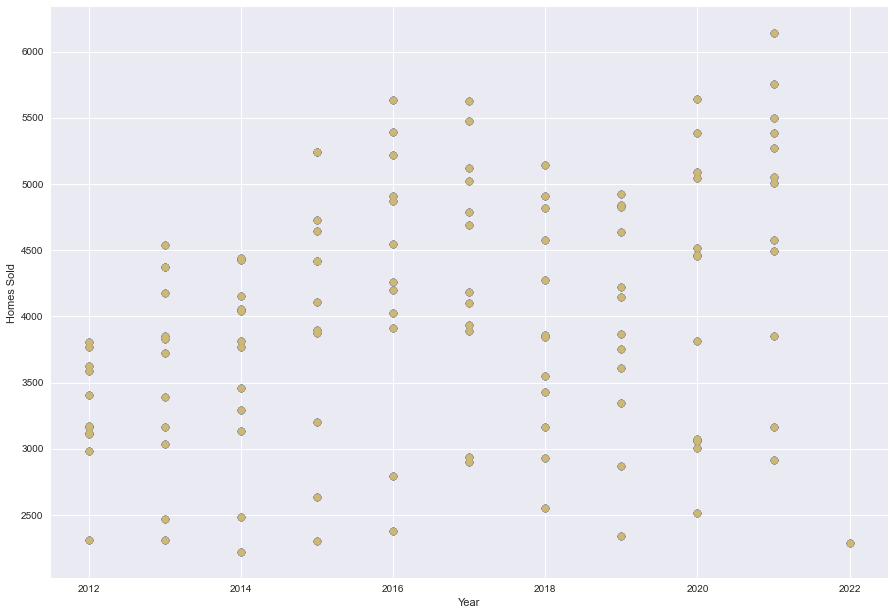

In [11]:
plt.figure(figsize=(15,10.5))
plot_count = 1

for feature in list(data_Seattle.columns)[:-1]:
        #plt.subplot(3,3, plot_count)
        plt.scatter(data_Seattle['year'], data_Seattle['Homes Sold'])
        plt.xlabel(feature.title())
        plt.ylabel('Homes Sold')
        plot_count+=1
        
plt.show()

In [12]:
# Determination of Correlation Coefficient Between years and homes sold natinally
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

correlations = data_national[['year','Homes Sold']].corr(method='pearson')
print(correlations)

             year  Homes Sold
year        1.000       0.479
Homes Sold  0.479       1.000


In [13]:
# Determination of Correlation Coefficient Between years and homes sold natinally
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

correlations = data_national[['year','Homes Sold']].corr(method='kendall')
print(correlations)

             year  Homes Sold
year        1.000       0.347
Homes Sold  0.347       1.000


In [14]:
# Determination of Correlation Coefficient Between years and homes sold natinally
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

correlations = data_national[['year','Homes Sold']].corr(method='spearman')
print(correlations)

             year  Homes Sold
year        1.000       0.469
Homes Sold  0.469       1.000


In [15]:
# Determination of Correlation Coefficient Between year and homes sold Seattle
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

correlations = data_Seattle[['year','Homes Sold']].corr(method='pearson')
print(correlations)

             year  Homes Sold
year        1.000       0.307
Homes Sold  0.307       1.000


In [16]:
# Determination of Correlation Coefficient Between year and homes sold Seattle
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

correlations = data_Seattle[['year','Homes Sold']].corr(method='kendall')
print(correlations)

             year  Homes Sold
year        1.000       0.233
Homes Sold  0.233       1.000


In [17]:
# Determination of Correlation Coefficient Between year and homes sold Seattle
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

correlations = data_Seattle[['year','Homes Sold']].corr(method='spearman')
print(correlations)

             year  Homes Sold
year        1.000       0.313
Homes Sold  0.313       1.000


In [18]:
#This data correlation for both national and Seattle 
# is not correlated using all 3 methods. 

In [19]:
#Setup a timeplot to observe patterns in this time-series data.

Text(0.5, 1.0, 'Homes Sales Trend')

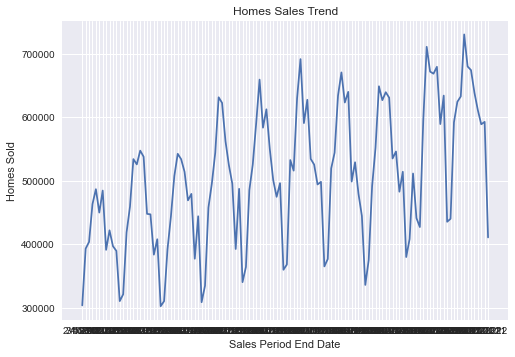

In [20]:
plt.plot(data_national['Month of Period End'], data_national['Homes Sold'])
plt.xlabel('Sales Period End Date')
plt.ylabel('Homes Sold')
plt.title('Homes Sales Trend')

In [21]:
# Evaluate for stationary using Dickey-Fuller

In [22]:
data_national_train, data_national_test = train_test_split(data_national, test_size=.3, shuffle=False) # Split data into train and test

In [23]:
data_Seattle_train, data_Seattle_test = train_test_split(data_Seattle, test_size=.3, shuffle=False) # Split data into train and test

In [24]:
def evaluate_stationarity(timeseries, t=30):
    # Determine rolling mean and std
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()
    
    # Plot those stats
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform DF test
    print("Results of the Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
        'p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput.loc['Critical Value (%s)'%key] = value
    
    return dfoutput

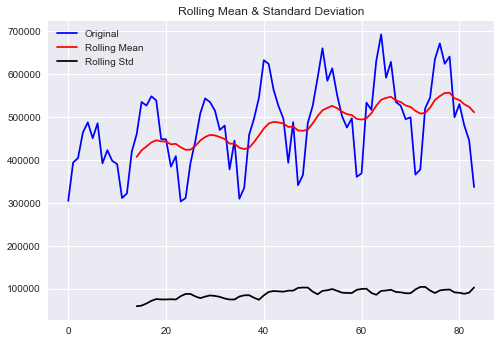

Results of the Dickey-Fuller Test:


Test Statistic                 -1.790
p-value                         0.386
#Lags Used                     12.000
Number of Observations Used    71.000
Critical Value (1%)            -3.526
Critical Value (5%)            -2.903
Critical Value (10%)           -2.589
dtype: float64

In [25]:
evaluate_stationarity(data_national_train['Homes Sold'], 15)

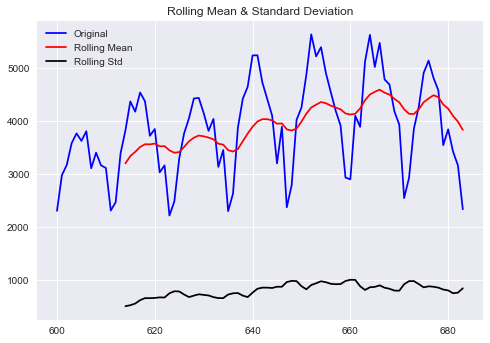

Results of the Dickey-Fuller Test:


Test Statistic                 -2.018
p-value                         0.279
#Lags Used                     12.000
Number of Observations Used    71.000
Critical Value (1%)            -3.526
Critical Value (5%)            -2.903
Critical Value (10%)           -2.589
dtype: float64

In [26]:
evaluate_stationarity(data_Seattle_train['Homes Sold'], 15)

In [27]:
# The observation here is that (and we can see this because rolling mean varies a lot) the time series is not stationary. 
# This is confirmed in that the test statistic is greater than the critical values in same way as the case study in Chapter 3 Haroon.

In [28]:
#Perform a log transformation to see if it makes the time-series statinary for national data.
data_national_train_log = np.log(data_national_train['Homes Sold'])
#evaluate_stationarity(data_national_train_log['Homes Sold'], 15)

In [29]:
#Perform a log transformation to see if it makes the time-series statinary for Seattle data.
data_Seattle_train_log = np.log(data_Seattle_train['Homes Sold'])
#evaluate_stationarity(data_Seattle_train_log['Homes Sold'], 15)

In [30]:
#Perform a sqrt transformation to see if it makes the time-series statinary for national data.
data_national_train_sqrt = np.sqrt(data_national_train['Homes Sold'])
#evaluate_stationarity(data_national_train_sqrt['Homes Sold'], 15)

In [31]:
#Perform a sqrt transformation to see if it makes the time-series statinary for national data.
data_Seattle_train_log = np.sqrt(data_national_train['Homes Sold'])
#evaluate_stationarity(data_national_train_sqrt['Homes Sold'], 15)

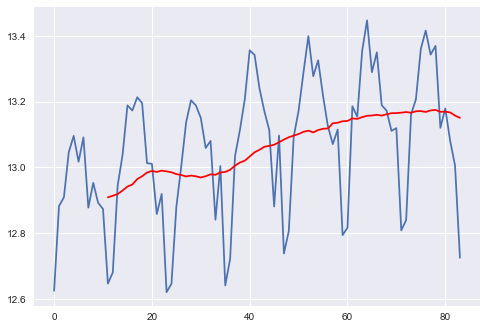

In [32]:
moving_avg = data_national_train_log.rolling(window=12).mean()
plt.plot(data_national_train_log)
plt.plot(moving_avg, color='red')

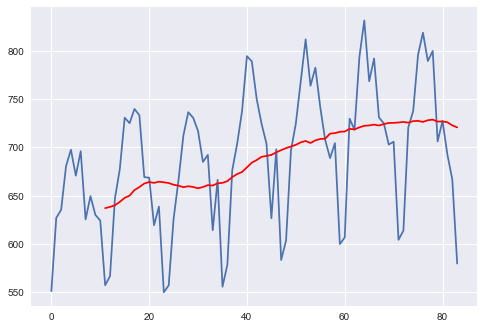

In [33]:
moving_avg2 = data_Seattle_train_log.rolling(window=12).mean()
plt.plot(data_Seattle_train_log)
plt.plot(moving_avg2, color='red')

In [34]:
data_national_train_log_moving_avg_diff = data_national_train_log - moving_avg
data_national_train_log_moving_avg_diff.head(15)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11   -0.262
12   -0.233
13    0.026
14    0.108
Name: Homes Sold, dtype: float64

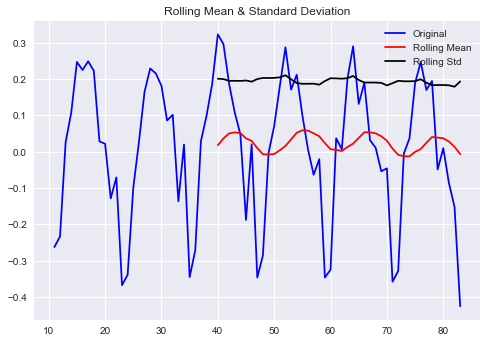

Results of the Dickey-Fuller Test:


Test Statistic                 -0.856
p-value                         0.802
#Lags Used                     12.000
Number of Observations Used    60.000
Critical Value (1%)            -3.544
Critical Value (5%)            -2.911
Critical Value (10%)           -2.593
dtype: float64

In [35]:
# Remove NAs
data_national_train_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_national_train_log_moving_avg_diff)

In [36]:
data_Seattle_train_log_moving_avg_diff = data_Seattle_train_log - moving_avg2
data_Seattle_train_log_moving_avg_diff.head(15)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11   -79.801
12   -71.614
13     7.000
14    34.053
Name: Homes Sold, dtype: float64

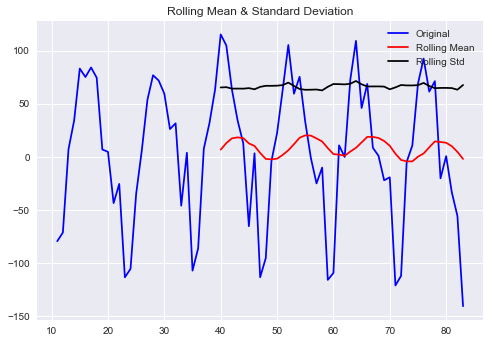

Results of the Dickey-Fuller Test:


Test Statistic                 -0.945
p-value                         0.773
#Lags Used                     12.000
Number of Observations Used    60.000
Critical Value (1%)            -3.544
Critical Value (5%)            -2.911
Critical Value (10%)           -2.593
dtype: float64

In [37]:
# Remove NAs
data_Seattle_train_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_Seattle_train_log_moving_avg_diff)

In [38]:
# Testing exponentially weighted moving average

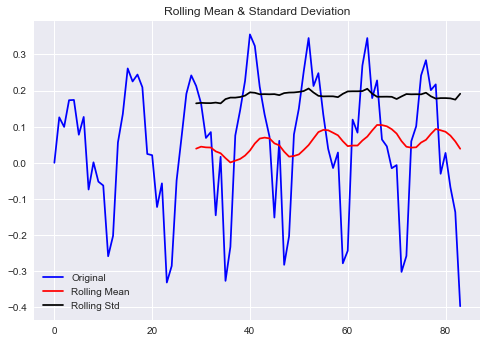

Results of the Dickey-Fuller Test:


Test Statistic                 -1.684
p-value                         0.439
#Lags Used                     12.000
Number of Observations Used    71.000
Critical Value (1%)            -3.526
Critical Value (5%)            -2.903
Critical Value (10%)           -2.589
dtype: float64

In [39]:
expweighted_avg = data_national_train_log.ewm(halflife=15).mean()
data_national_train_log_expweighted_avg_diff = data_national_train_log - expweighted_avg
evaluate_stationarity(data_national_train_log_expweighted_avg_diff)

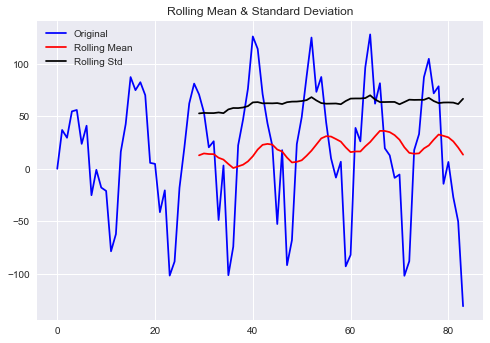

Results of the Dickey-Fuller Test:


Test Statistic                 -1.744
p-value                         0.409
#Lags Used                     12.000
Number of Observations Used    71.000
Critical Value (1%)            -3.526
Critical Value (5%)            -2.903
Critical Value (10%)           -2.589
dtype: float64

In [40]:
expweighted_avg2 = data_Seattle_train_log.ewm(halflife=15).mean()
data_Seattle_train_log_expweighted_avg_diff = data_Seattle_train_log - expweighted_avg2
evaluate_stationarity(data_Seattle_train_log_expweighted_avg_diff)

In [41]:
# Trying differencing method

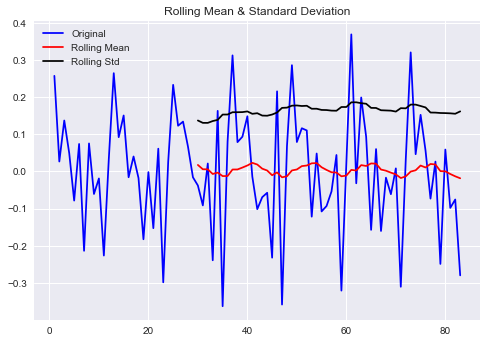

Results of the Dickey-Fuller Test:


Test Statistic                 -2.335
p-value                         0.161
#Lags Used                     12.000
Number of Observations Used    70.000
Critical Value (1%)            -3.527
Critical Value (5%)            -2.904
Critical Value (10%)           -2.589
dtype: float64

In [42]:
data_national_train_log_diff = data_national_train_log - data_national_train_log.shift()
data_national_train_log_diff.dropna(inplace=True)
evaluate_stationarity(data_national_train_log_diff)

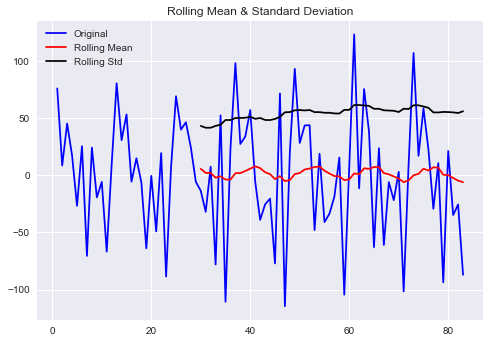

Results of the Dickey-Fuller Test:


Test Statistic                 -2.487
p-value                         0.119
#Lags Used                     12.000
Number of Observations Used    70.000
Critical Value (1%)            -3.527
Critical Value (5%)            -2.904
Critical Value (10%)           -2.589
dtype: float64

In [43]:
data_Seattle_train_log_diff = data_Seattle_train_log - data_Seattle_train_log.shift()
data_Seattle_train_log_diff.dropna(inplace=True)
evaluate_stationarity(data_Seattle_train_log_diff)

In [44]:
# For both the national and Seattle data, the differencing method provides the best statistical correlation
# Eliminate trend and seasonality using decompostion

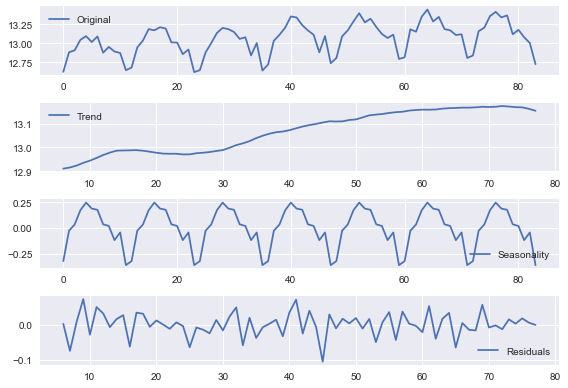

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_national_train_log, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_national_train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

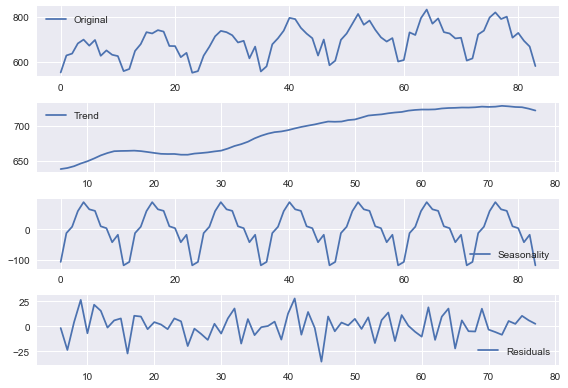

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition2 = seasonal_decompose(data_Seattle_train_log, period=12)

trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(data_Seattle_train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

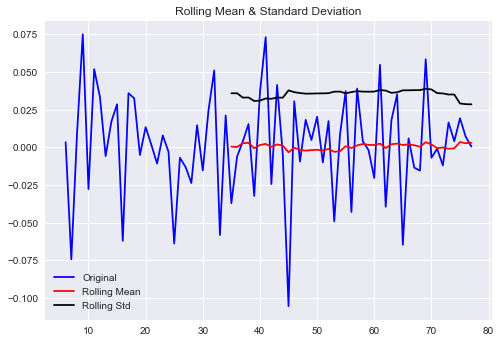

Results of the Dickey-Fuller Test:


Test Statistic                -5.519e+00
p-value                        1.899e-06
#Lags Used                     4.000e+00
Number of Observations Used    6.700e+01
Critical Value (1%)           -3.532e+00
Critical Value (5%)           -2.906e+00
Critical Value (10%)          -2.590e+00
dtype: float64

In [47]:
data_national_train_log_decompose = pd.Series(residual)
data_national_train_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_national_train_log_decompose)

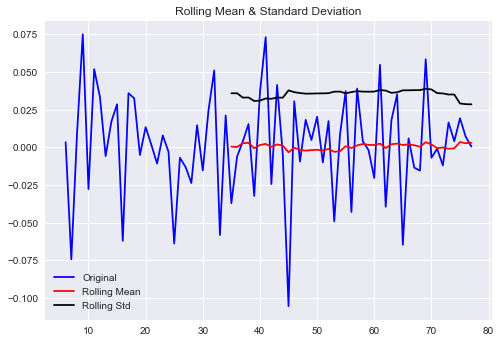

Results of the Dickey-Fuller Test:


Test Statistic                -5.519e+00
p-value                        1.899e-06
#Lags Used                     4.000e+00
Number of Observations Used    6.700e+01
Critical Value (1%)           -3.532e+00
Critical Value (5%)           -2.906e+00
Critical Value (10%)          -2.590e+00
dtype: float64

In [48]:
data_Seattle_train_log_decompose = pd.Series(residual)
data_Seattle_train_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_Seattle_train_log_decompose)

In [49]:
#This improved the correlation a lot for both national and Seattle data.

In [50]:
# Check for autocorrelation on National data
from statsmodels.stats.stattools import durbin_watson
durbin_watson(data_national_train_log_diff)

2.0409195290650883

In [51]:
# Checking for autocorrelation on Seattle data
durbin_watson(data_Seattle_train_log_diff)

2.0438708681417976

In [52]:
# Both datasets have no autocorrelation

C:\Users\fikir\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


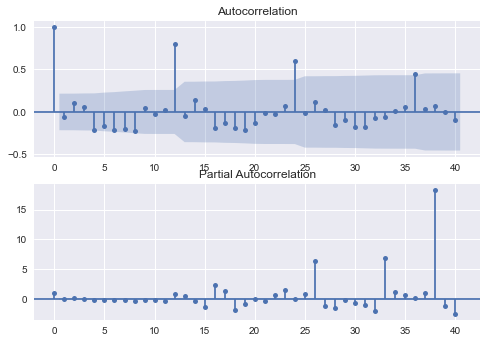

In [53]:
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_national_train_log_diff.squeeze(), lags=40, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_national_train_log_diff.squeeze(), lags=40, ax=ax2)

C:\Users\fikir\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


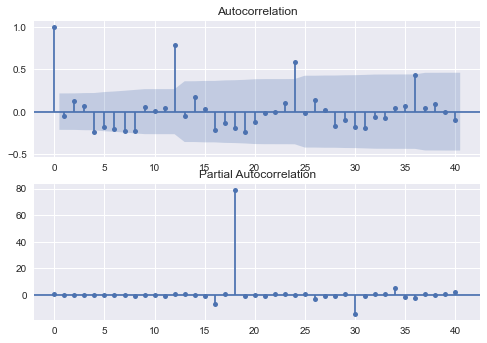

In [54]:
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_Seattle_train_log_diff.squeeze(), lags=40, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_Seattle_train_log_diff.squeeze(), lags=40, ax=ax2)

In [55]:
# Modelling of the time-series. Focus on Number of Auto-Regressive terms (p), Number of Moving Average terms (q), and Number of differences (d).

In [60]:
# ARIMA
model = ARIMA(data_national_train_log.values, order=(2,1,0), dates=data_national_train_log.index.snap('D'))
results_AR_210 = model.fit()
plt.plot(data_national_train_log_diff)
plt.plot(pd.Series(results_AR_210.fittedvalues, index=data_national_train_log.index[1:]), color='red')
plt.title('RSS: %.4f'% sum((results_AR_210.fittedvalues-data_national_train_log_diff)**2))

AttributeError: 'Int64Index' object has no attribute 'snap'

In [ ]:
#This analysis shows the ability to take some take historical data and apply time-series forecasting to
#predict future outcomes. In my project I applied it to housing market predictions. THis helps tell when to buy
#and sell homes if it is a buyers' or sellers' market. THe prediction model forecasts estimated home cost in the future.